In [8]:
import pandas as pd
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cbpro

public_client = cbpro.PublicClient()


In [12]:
class MinerMeta(type):
    def compile_historic(self):
        start_date = datetime(2020, 1, 1)
        end_date = datetime.today()
        delta = timedelta(hours=300)
        df = pd.DataFrame()

        while start_date <= end_date:
            historic = public_client.get_product_historic_rates(
                f"{self.coin}-USD",
                granularity=3600,
                start=start_date,
                end=start_date + delta,
            )
            start_date += delta
            df = df.append(historic, ignore_index=True)
        df.columns = ["time", "low", "high", "open", "close", "volume"]
        date_time = pd.to_datetime(df["time"], unit="s")

        timestamp_s = date_time.map(pd.Timestamp.timestamp)
        day = 24 * 60 * 60
        year = (365.2425) * day
        df["Day sin"] = np.sin(timestamp_s * (2 * np.pi / day))
        df["Day cos"] = np.cos(timestamp_s * (2 * np.pi / day))
        df["Year sin"] = np.sin(timestamp_s * (2 * np.pi / year))
        df["Year cos"] = np.cos(timestamp_s * (2 * np.pi / year))
        df.reset_index(drop=True, inplace=True)
        # df["time"] = pd.to_datetime(df["time"], unit="s")
        # df["time"] = date_time.map(pd.Timestamp.timestamp)

        # data = np.array(df, dtype=np.float32)
        # ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        #     data=df,
        #     targets="close",
        #     sequence_length=10,
        #     sequence_stride=1,
        #     shuffle=False,
        #     batch_size=64,
        # )

        return df

    def plot_cols(self, cols=None):
        df = self.compile_historic()
        if cols == None:
            plot_features = df[list(df.columns)]
        else:
            plot_features = df[cols]
        plot_features.index = df["time"]
        return plot_features.plot(subplots=True)

    def do_fft(self):
        df = self.compile_historic()
        today = datetime.today()
        
        og = df["open"]
        fft = tf.signal.rfft(df["open"])
        close_fft = tf.signal.rfft(df["close"])
        f_per_dataset = np.arange(0, len(fft))

        n_samples_h = 1
        hours_per_year = 24*365.2524
        years_per_dataset = n_samples_h/(hours_per_year)

        f_per_year = f_per_dataset/years_per_dataset
        plt.step(f_per_year, np.abs(fft))
        plt.xscale('log')
        # plt.ylim(1000, 50000)
        # plt.xlim([0.1, max(plt.xlim())])
        plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
        plt.xlabel('Frequency (log scale)')

        return plt.show()


    # def make_dataset(data):
    #     data = np.array(data, dtype=np.float32)
    #     ds = tf.keras.preprocessing.timeseries_dataset_from_array(
    #         data=data,
    #         targets="close",
    #         sequence_length=10,
    #         sequence_stride=1,
    #         shuffle=False,
    #         batch_size=64,
    #     )

    #     return ds

    def __call__(self, *args, **kwargs):

        cls = type.__call__(self, *args)

        setattr(cls, "compile_historic", self.compile_historic)
        setattr(cls, "plot_cols", self.plot_cols)
        setattr(cls, "do_fft", self.do_fft)
        # setattr(cls, "make_dataset", self.compile_historic)

        # for key, value in historic.items():
        #     setattr(cls, "hist_" + key, value)
        # for key, value in ticker.items():
        #     setattr(cls, "tick_" + key, value)

        return cls


class eth(metaclass=MinerMeta):
    coin = "eth"


class btc(metaclass=MinerMeta):
    coin = "btc"


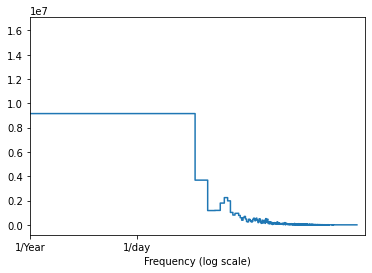

,time,low,high,open,close,volume,Day sin,Day cos,Year sin,Year cos
0,1578916800,142.55,143.16,142.63,142.97,1225.912140,4.870313e-12,-1.000000,0.211280,0.977426
1,1578913200,142.61,143.81,143.68,142.71,1045.119622,2.588190e-01,-0.965926,0.210579,0.977577
2,1578909600,142.72,143.96,143.05,143.68,2473.324779,5.000000e-01,-0.866025,0.209879,0.977727
3,1578906000,142.68,143.44,143.40,143.08,407.567872,7.071068e-01,-0.707107,0.209178,0.977878
4,1578902400,142.43,143.39,142.69,143.20,749.472507,8.660254e-01,-0.500000,0.208477,0.978027


In [13]:
eth = eth()

df = eth.compile_historic()

eth.do_fft()

df.head()